In [2]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
import ants
import warnings

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/ants/regrid/esmf.py:26: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/ants/regrid/_ugrid.py:19: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/iris/experimental/raster.py:29: IrisDeprecation: iris.experimental.raster is deprecated since version 3.2, and will be removed in a future release. If you make use of this functionality, please contact the Iris Developers to discuss how to retain it (which may involve reversing the deprecation).
  warn_deprecated(wmsg)


In [22]:
# file = "/g/data/access/TIDS/UM/ancil/atmos/GC5/n640e/aerosol_clims/glomap/360day/v1/qrclim.aerosols85.nc"
# file = "/g/data/gb02/public/AM3/ancils/u-dj813_om3-025deg/n512e/ozone/sparc/1994-2005/qrclim.ozone_L85_O85"
# file= "/g/data/vk83/prerelease/configurations/inputs/access-cm3/ancil/2025.07.25/n216e/aerosol_clims/glomap/360day/qrclim.aerosols85.nc"
file = "/scratch/gb02/pc2687/ancils/ozone/n512e/qrclim.ozone_L85_O85"

cubes = ants.load(file)

In [10]:
cubes

Mass Fraction Of Ozone In Air (1),time,model_level_number,latitude,longitude
Shape,12,85,324,1
Dimension coordinates,,,,
time,x,-,-,-
model_level_number,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
level_height,-,x,-,-
sigma,-,x,-,-
Cell methods,,,,


In [6]:
def collapse_cube(cube):
    """
    Collapse a cube onto lat/lon dimensions via averaging
    """
    collapse_dims = []
    
    for coord in cube.coords():
        if coord not in cube.dim_coords:
            collapse_dims.append(coord.name())
            # print (f'For {cube.name()} coordinate {coord.name()} will be collapsed')
            
    # Check if time remains
    if 'time' in [ c.name() for c in cube.dim_coords ]: 
        collapse_dims.append('time')
        # print (f'For variable {cube.name()} coordinate time will be collapsed')
    new_cube = cube.collapsed(collapse_dims,iris.analysis.MIN)

    return new_cube

In [5]:
n_negatives = []

for cube in cubes:

    cube = collapse_cube(cube)
    negatives = np.sum(cube.data < 0)
    n_negatives.append(negatives)
    print(f"{cube.name()}: {negatives} negative values")


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'model_level_number', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'model_level_number'. Ignoring bounds.
  warnings.warn(


mass_fraction_of_ozone_in_air: 960 negative values


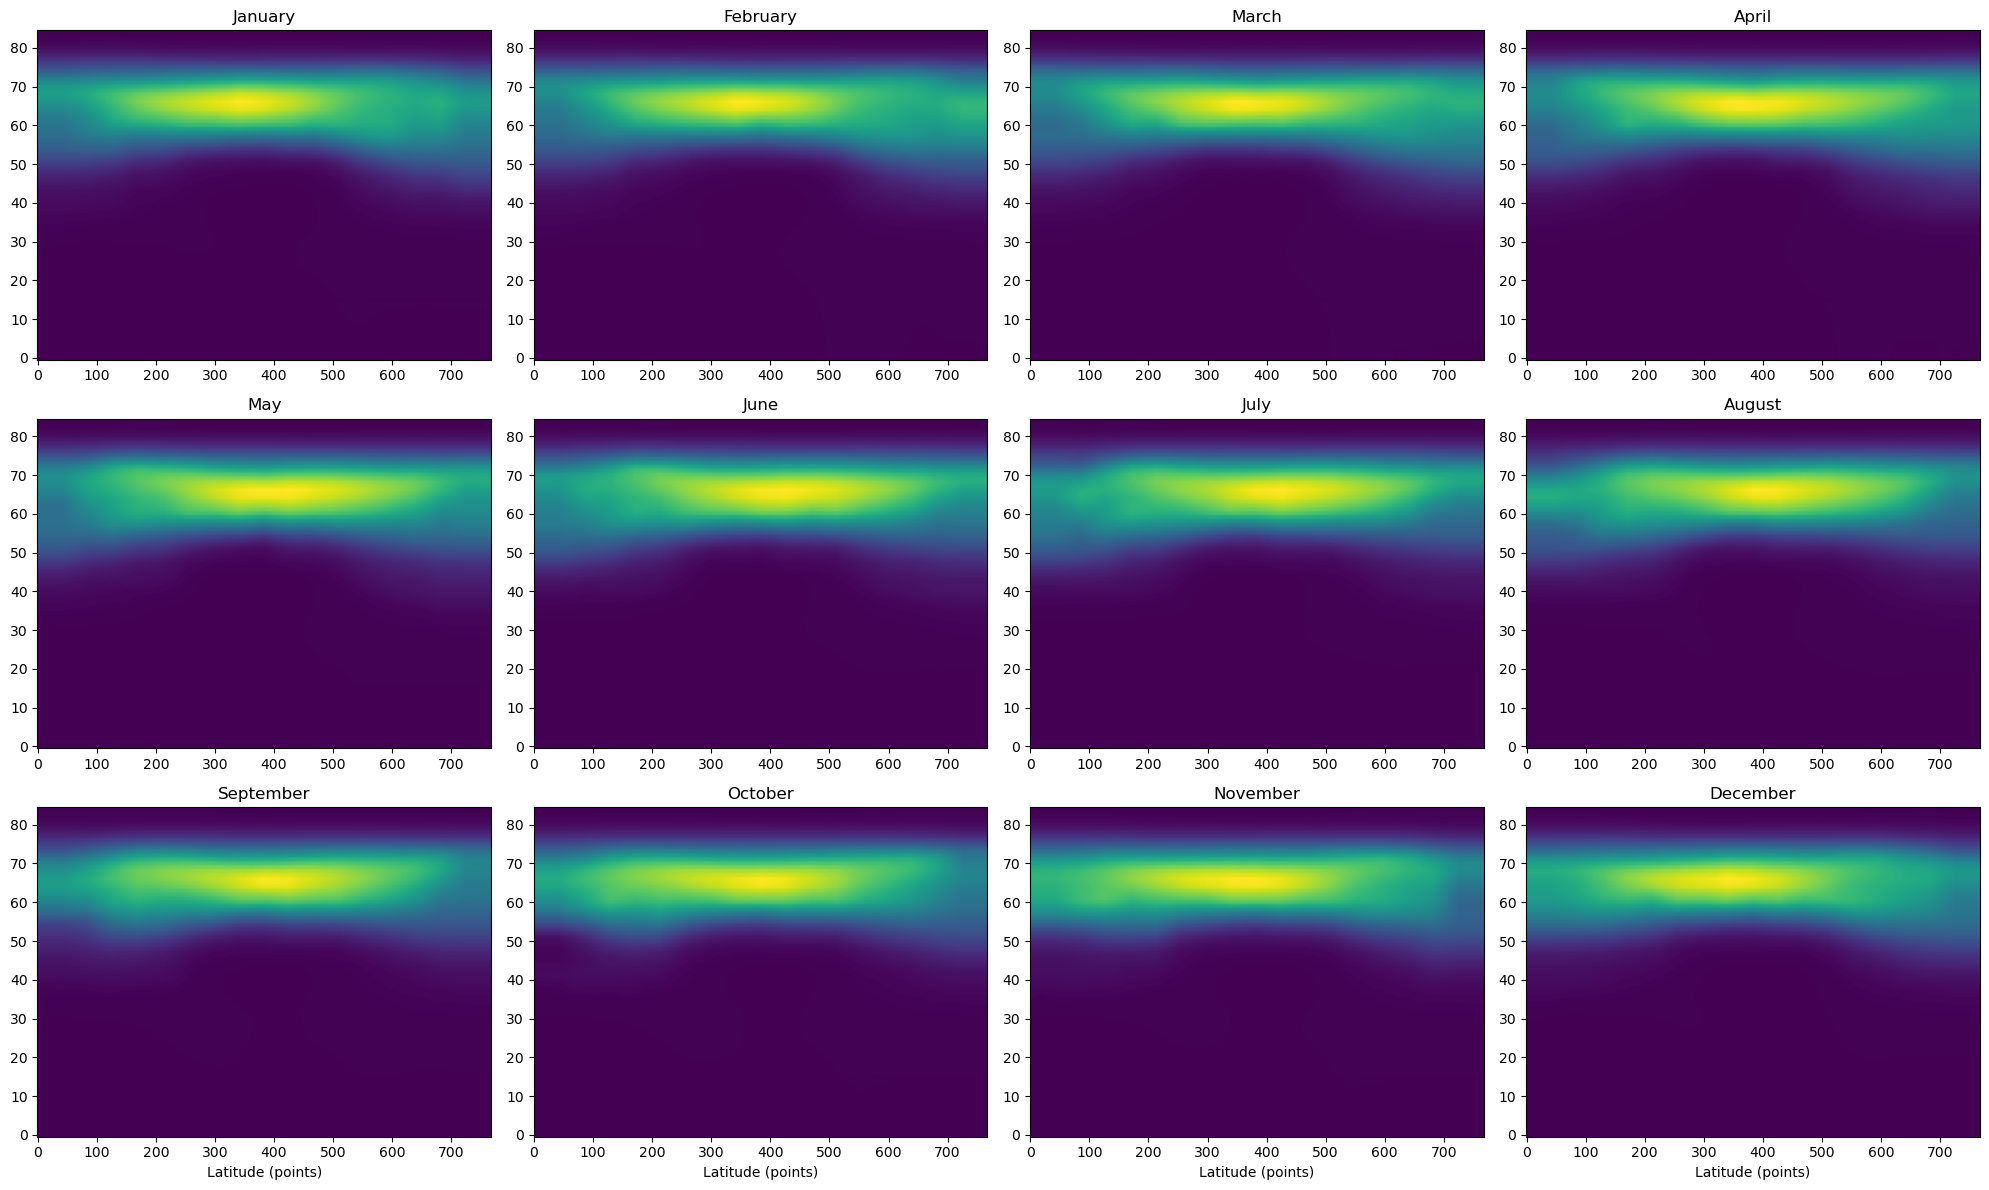

In [23]:
ozone_values = cubes[0].data

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()
months = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]


for i in range(12):
    ax = axes[i]
    im = ax.imshow(ozone_values[i,:,:,0], cmap='viridis', aspect='auto')
    ax.set_title(months[i])
    ax.invert_yaxis()

    y, x = np.where(ozone_values[i,:,:,0] < 0)
    # Overlay black circles on anomalous negatives
    ax.scatter(x, y, marker='o', s=60, facecolors='none', edgecolors='red', linewidths=2)

    if i // 4 == 2:  # Only for the bottom row (indices 8,9,10,11)
        ax.set_xlabel('Latitude (points)')

plt.tight_layout()
plt.show()